# Project 4: Using Data Science to Gain Insights from Stack Overflow Survey Data

For this project I am using the Stack Overflow Data - 2017 Survey available [here](https://www.kaggle.com/stackoverflow/so-survey-2017).

## Step 1: Business Understanding

As stated on that site:
> Every year, Stack Overflow conducts a massive survey of people on the site, covering all sorts of information like programming languages, salary, code style and various other information. This year, they amassed more than 64,000 responses fielded from 213 countries.

This is information provided by individuals about themselves and their opinions. The individuals are either developers or have some connection to developers / development.

I will be looking to answer three main questions through the use of Data Science principles:
1. What level of education do parents of self-taught professional developers have?
2. How well can we predict an individual's highest level of formal education? What aspects correlate well to this?
3. How well can we predict whether an individual sees the world in "black and white" or not? What aspects correlate well to this?

## Interlude: Key Includes

Prior to moving on to understanding our data we need to prepare our development environment with the different libraries we will need for working with the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

%matplotlib inline

## Step 2: Data Understanding

In this step we will load in the data and schema and take a look at the two of them to better understand what details we have available in the data and how we might use it to answer our three main questions.

### Load in the Data and Schema

In [2]:
survey_results = pd.read_csv('./data/survey_results_public.csv')
survey_schema = pd.read_csv('./data/survey_results_schema.csv')

### Understand the Structure of the Data

In [3]:
survey_results.shape

(51392, 154)

In [4]:
survey_results.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
survey_schema.shape

(154, 2)

In [6]:
survey_schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


From looking at the data and schema it is clear that there is a lot of nominal categorical features (e.g. "In which country do you currently live?") as well as some ordinal features. I will need to do some preparation of the data before I can model it.

## Interlude: Question 1

It appears that I should be able to answer my first question without needing to do any modeling.

As a reminder, my first question is:
1. What level of education do parents of self-taught professional developers have?

The key features that I will need to look at for this question are Professional, EducationTypes and HighestEducationParents.

In [7]:
# Let's look at the values in the Professional feature.

survey_results.Professional.value_counts()

Professional developer                                  36131
Student                                                  8224
Professional non-developer who sometimes writes code     5140
Used to be a professional developer                       983
None of these                                             914
Name: Professional, dtype: int64

In this situation, I want to include those individuals who chose "Professional developer" or "Used to be a professional developer" since I myself fall into the second bucket.

In [8]:
# Let's look at the values in the EducationTypes feature.

survey_results.EducationTypes.value_counts()

Self-taught                                                                                                        3691
Online course; Self-taught                                                                                         1875
Self-taught; Open source contributions                                                                             1751
On-the-job training; Self-taught                                                                                   1687
Online course; On-the-job training; Self-taught                                                                    1276
                                                                                                                   ... 
Online course; Bootcamp; On-the-job training; Coding competition; Hackathon                                           1
Online course; Bootcamp; Industry certification; Coding competition; Hackathon; Open source contributions             1
Online course; Part-time/evening course;

Ruh roh! It looks like this is a question that allows for multiple answers! We will need to do something about this.

We have a few different options:
1. Only count those people who ONLY selected "Self-taught".
2. Break the feature up into multiple features in the dataset: one for each value chosen.
3. Use a dynamic query to only choose those rows that include the text "Self-taught" without actually creating new features.

I am going to choose Option 1. This may seem like the "easy route" (and it is, of course) but it also has value: this way we are truly looking at only those who were self-taught and did not learn through a different method (e.g. an Online course). This is what I am truly trying to understand.

In [9]:
# Create a new dataframe only including those rows where Professional == "Professional 
# developer" or "Used to be a professional developer" and EducationTypes == "Self-taught"

self_taught = survey_results[((survey_results.Professional == "Professional developer") |
                              (survey_results.Professional == "Used to be a professional developer")) &
                             (survey_results.EducationTypes == 'Self-taught')]
self_taught.shape

(2480, 154)

In [10]:
# Now that we have a dataframe focused only on Self-taught professional developers, let's
# take a look at the values in the HighestEducationParents feature for those records.

par_ed_vals = self_taught.HighestEducationParents.value_counts()

par_ed_vals

A bachelor's degree                                    537
A master's degree                                      417
High school                                            404
Some college/university study, no bachelor's degree    272
Primary/elementary school                              108
A doctoral degree                                       90
A professional degree                                   89
I don't know/not sure                                   51
I prefer not to answer                                  37
No education                                            14
Name: HighestEducationParents, dtype: int64

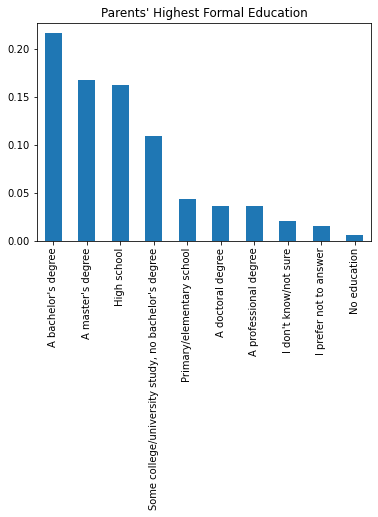

In [11]:
# Let's plot these in a bar chart to see it more visually.

(par_ed_vals/self_taught.shape[0]).plot(kind="bar");
plt.title("Parents' Highest Formal Education");

This shows that about half of the Self-taught developers have parents who had at least some college / university study.

What would be really interesting is to see how that compares to the survey participants overall...

In [12]:
# Let's take a look at the values in the HighestEducationParents feature for all records.

par_ed_vals_tot = survey_results.HighestEducationParents.value_counts()

par_ed_vals_tot

A bachelor's degree                                    10175
A master's degree                                       7561
High school                                             5887
Some college/university study, no bachelor's degree     4783
A doctoral degree                                       2060
A professional degree                                   1546
Primary/elementary school                               1378
I don't know/not sure                                    726
I prefer not to answer                                   612
No education                                             210
Name: HighestEducationParents, dtype: int64

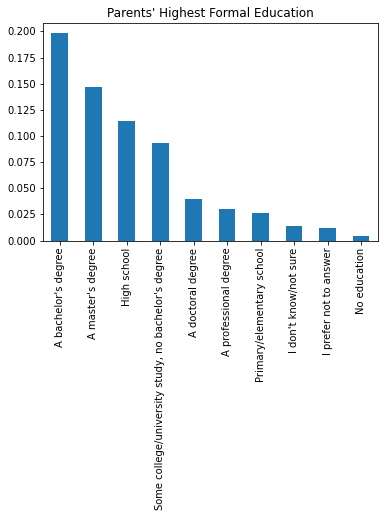

In [13]:
# Let's plot these in a bar chart to see it more visually.

(par_ed_vals_tot/survey_results.shape[0]).plot(kind="bar");
plt.title("Parents' Highest Formal Education");

The shape of the data between the self-taught developers and the survey participants overall is very similar with most buckets (e.g. "A bachelor's degree") coming in at almost the same place in terms of percentage of the total.

There are two aspects that I would like to call out...
- The % of those whose parents have a bachelor's degree or master's degree (higher education) increased.
- The % of those whose parents have primary / elementary school education (basic formal education) increased.

What can we glean from this information? I will discuss it in my blog post ;)

## Step 3: Data Preparation

In order to answer the other two questions I will need to some modeling so I must next go about preparing the data.

### Reviewing Null (NaN) Values

Before modeling it is important for me to understand the NaN values in the dataset.

In [14]:
# Print the # of NaN values by column in the survey results.

for col in survey_results:
    col_nan = survey_results[col].isnull().sum()
    print(col, col_nan)

Respondent 0
Professional 0
ProgramHobby 0
Country 0
University 0
EmploymentStatus 0
FormalEducation 0
MajorUndergrad 8551
HomeRemote 7384
CompanySize 12470
CompanyType 12569
YearsProgram 247
YearsCodedJob 10502
YearsCodedJobPast 50418
DeveloperType 15267
WebDeveloperType 40696
MobileDeveloperType 49839
NonDeveloperType 46502
CareerSatisfaction 8697
JobSatisfaction 11016
ExCoderReturn 50469
ExCoderNotForMe 50471
ExCoderBalance 50469
ExCoder10Years 50475
ExCoderBelonged 50464
ExCoderSkills 50457
ExCoderWillNotCode 50470
ExCoderActive 50462
PronounceGIF 384
ProblemSolving 20099
BuildingThings 20158
LearningNewTech 20088
BoringDetails 20208
JobSecurity 20152
DiversityImportant 20489
AnnoyingUI 20371
FriendsDevelopers 20335
RightWrongWay 20408
UnderstandComputers 20345
SeriousWork 20378
InvestTimeTools 20506
WorkPayCare 20427
KinshipDevelopers 20690
ChallengeMyself 20421
CompetePeers 20582
ChangeWorld 20457
JobSeekingStatus 18012
HoursPerWeek 30792
LastNewJob 18682
AssessJobIndustry 29262


This shows us that the FormalEducation feature has 0 NaN values (it must have been required) which means that we do not need to remove any rows for answering the second question.

This also shows us that RightWrongWay feature has a significant # of NaN values (20408 out of 51392 total responses) so our answer for the third question may be heavily biased by those who chose to respond.

In [15]:
# Prepare the X and y sets for the second question. Much of this was copied from the
# "Putting it All Together - Solution" in this lesson on Udacity (thanks!).

X2 = survey_results
y2 = X2['FormalEducation'].astype('category').cat.codes

# Drop the Respondent and FormalEducation columns from X2
X2 = X2.drop(['Respondent', 'FormalEducation'], axis=1)

# Fill numeric columns with the mean
num_vars = X2.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    X2[col].fillna((X2[col].mean()), inplace=True)
        
# Dummy the categorical variables
cat_vars = X2.select_dtypes(include=['object']).copy().columns
for var in cat_vars:
    # for each cat add dummy var, drop original column
    X2 = pd.concat([X2.drop(var, axis=1), pd.get_dummies(X2[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [16]:
# Prepare the X and y sets for the third question. Much of this was copied from the
# "Putting it All Together - Solution" in this lesson on Udacity (thanks!).

# Drop rows with missing RightWrongWay values
X3 = survey_results.dropna(subset=['RightWrongWay'], axis=0)
y3 = X3['RightWrongWay'].astype('category').cat.codes

# Drop the Respondent and RightWrongWay columns from X3
X3 = X3.drop(['Respondent', 'RightWrongWay'], axis=1)

# Fill numeric columns with the mean
num_vars = X3.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    X3[col].fillna((X3[col].mean()), inplace=True)
        
# Dummy the categorical variables
cat_vars = X3.select_dtypes(include=['object']).copy().columns
for var in cat_vars:
    # for each cat add dummy var, drop original column
    X3 = pd.concat([X3.drop(var, axis=1), pd.get_dummies(X3[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

## Step 4: Modeling

Now that our data has been prepared we can go ahead and model it based upon the questions that we are asking (and features we are trying to predict).

### Common Function for Modeling

Our first step should be to create a common function that can be used for both questions to model the data.

In [17]:
# Much of this is taken from the find_optimal_lm_mod function in the AllTogether.py file
# on Udacity (thanks!).

def model_our_data(X, y, cutoff = 10, test_size = .30, random_state = 42):
    #reduce the columns with many null values
    X = X.iloc[:, np.where((X.sum() > int(cutoff)) == True)[0]]
    
    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    
    #fit the model
    lm_model = LogisticRegression(random_state = random_state)
    lm_model.fit(X_train, y_train)
    
    #predict using the model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    
    #evaluate the model
    accuracy_score_test = accuracy_score(y_test, y_test_preds)
    accuracy_score_train = accuracy_score(y_train, y_train_preds)
    r2_score_test = r2_score(y_test, y_test_preds)
    r2_score_train = r2_score(y_train, y_train_preds)
    
    return r2_score_test, r2_score_train, accuracy_score_test, accuracy_score_train, lm_model, X_train, X_test, y_train, y_test

### Modeling for Question 2

Now we are ready to model for the second question.

As a reminder, my second question is:

2. How well can we predict an individual's highest level of formal education? What aspects correlate well to this?

In [18]:
r2_score_test2, r2_score_train2, accuracy_score_test2, accuracy_score_train2, lm_model2, X_train2, X_test2, y_train2, y_test2 = model_our_data(X2, y2)

print('accuracy_score_test2: ', accuracy_score_test2)
print('accuracy_score_train2: ', accuracy_score_train2)
print('r2_score_test2: ', r2_score_test2)
print('r2_score_train2: ', r2_score_train2)

accuracy_score_test2:  0.4213257231806979
accuracy_score_train2:  0.4201089675877022
r2_score_test2:  -1.028283933979266
r2_score_train2:  -1.0404334160191517


Well, this clearly shows that my model does not do a very good job of predicting the highest education level of the developer.

I tweaked my model a bit but still got poor results. Why? I will discuss my thoughts on it in my blog post ;)

### Modeling for Question 3

Now we can model for the third question.

As a reminder, my third question is:

3. How well can we predict whether an individual sees the world in "black and white" or not? What aspects correlate well to this?

In [19]:
r2_score_test3, r2_score_train3, accuracy_score_test3, accuracy_score_train3, lm_model3, X_train3, X_test3, y_train3, y_test3 = model_our_data(X3, y3)

print('accuracy_score_test3: ', accuracy_score_test3)
print('accuracy_score_train3: ', accuracy_score_train3)
print('r2_score_test3: ', r2_score_test3)
print('r2_score_train3: ', r2_score_train3)

accuracy_score_test3:  0.3145438898450947
accuracy_score_train3:  0.32225193655477685
r2_score_test3:  -0.1667337524875463
r2_score_train3:  -0.16409152378519787


Well, this clearly shows that my model does not do a very good job of predicting the whether a developer sees the world in black-and-white or not.

I tweaked my model a bit but still got poor results. Why? I will discuss my thoughts on it in my blog post ;)

## Step 5: Evaluation

Now that we have completed our modeling and have predictions based upon our models we can evaluate the models and the most important features in each.

Though my models did not do well for answering the second and third questions it is still worthwhile to look at the coefficients (features) that had the most impact on them.

In [20]:
# Create a dataframe showing which coefficients (features) had the highest weights in the model. Much of this
# came from the "Putting it All Together - Solution" in this lesson on Udacity (thanks!).
def coef_weights(lm_model_c, X_train_c):
    '''
    INPUT:
    lm_model_c - the logistic regression model 
    X_train_c - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient and estimate
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame(lm_model_c.coef_[0],
                            X_train_c.columns, 
                            columns=['coef'])\
                            .sort_values(by='coef', ascending=False)
    return coefs_df

In [21]:
#Use the function
coef_X2 = coef_weights(lm_model2, X_train2)

#A quick look at the top results
coef_X2.head(20)

,coef
ExpectedSalary,4.578003e-05
Salary,1.036630e-05
HoursPerWeek,1.752873e-07
StackOverflowSatisfaction,1.746499e-07
CareerSatisfaction,1.107485e-07
MajorUndergrad_Computer science or software engineering,1.004259e-07
Professional_Professional developer,8.423169e-08
JobSatisfaction,6.094954e-08
DeveloperType_Web developer,4.424640e-08
University_No,4.385884e-08


From the "coef" column we can see that no columns had a very strong impact on this model. What can we determine from these results if anything? I will discuss my thoughts on it in my blog post ;)

In [22]:
#Use the function
coef_X3 = coef_weights(lm_model3, X_train3)

#A quick look at the top results
coef_X3.head(20)

,coef
ExpectedSalary,1.029593e-05
HoursPerWeek,1.394064e-08
StackOverflowSatisfaction,1.080692e-08
CareerSatisfaction,4.192045e-09
Country_India,3.754933e-09
Race_South Asian,2.329580e-09
"PronounceGIF_With a soft ""g,"" like ""jiff""",2.073146e-09
Currency_Indian rupees (?),2.060487e-09
"CompanyType_Privately-held limited company, not in startup mode",1.756120e-09
TabsSpaces_Tabs,1.659905e-09


From the "coef" column we can see that no columns had a very strong impact on this model. What can we determine from these results if anything? I will discuss my thoughts on it in my blog post ;)